In [1]:
import re
import os
import warnings
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import xgboost as xgb
from scipy import stats
from collections import Counter
from xgboost import XGBRegressor
from sklearn.preprocessing import StandardScaler, MinMaxScaler, LabelEncoder
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2
from sklearn.model_selection import train_test_split
from tensorflow.keras.layers import Dense, Dropout, Activation
from tensorflow.keras.optimizers import SGD, Adam
from tensorflow.keras.models import Sequential
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error, accuracy_score

In [3]:
data = pd.read_excel("/Users/nithya/Downloads/J comp/data/combined (1) (1).xlsx")

In [4]:
data.head()

,time(UTC),Temp,Humidity,Radiation,Gb(n),Gd(h),IR(h),WindSpeed,WindDirection,AirPressure,State
0,20150121:0700,19.78,47.65,693.0,861.38,138.0,297.80,1.17,158,90845,arunachal pradesh
1,20150116:0600,18.66,43.25,716.0,901.63,125.0,317.80,1.10,6,90712,arunachal pradesh
2,20150201:1200,18.00,60.40,89.0,301.51,48.0,318.60,1.66,96,98809,punjab
3,20151007:0500,27.58,88.55,606.0,220.19,419.0,438.05,0.21,149,99530,tripura
4,20151007:1100,33.38,37.55,247.0,404.76,120.0,409.05,1.59,334,99158,uttar pradesh


In [5]:
df = data.copy()

In [6]:
month = []
year = []
day = []
hour = []
for y in range(0,len(df)):
    x = df['time(UTC)'][y]
    year.append(x[:4])
    month.append(x[4:6])
    day.append(x[6:8])
    hour.append(x[9:11])
df['Year'] = year
df['Month'] = month
df['Day'] = day
df['Hour'] = hour

In [7]:
df.head()

,time(UTC),Temp,Humidity,Radiation,Gb(n),Gd(h),IR(h),WindSpeed,WindDirection,AirPressure,State,Year,Month,Day,Hour
0,20150121:0700,19.78,47.65,693.0,861.38,138.0,297.80,1.17,158,90845,arunachal pradesh,2015,01,21,07
1,20150116:0600,18.66,43.25,716.0,901.63,125.0,317.80,1.10,6,90712,arunachal pradesh,2015,01,16,06
2,20150201:1200,18.00,60.40,89.0,301.51,48.0,318.60,1.66,96,98809,punjab,2015,02,01,12
3,20151007:0500,27.58,88.55,606.0,220.19,419.0,438.05,0.21,149,99530,tripura,2015,10,07,05
4,20151007:1100,33.38,37.55,247.0,404.76,120.0,409.05,1.59,334,99158,uttar pradesh,2015,10,07,11


In [8]:
df.drop(['time(UTC)', 'Gb(n)', 'Gd(h)', 'IR(h)'], axis = 1, inplace = True)

In [9]:
df.head()

,Temp,Humidity,Radiation,WindSpeed,WindDirection,AirPressure,State,Year,Month,Day,Hour
0,19.78,47.65,693.0,1.17,158,90845,arunachal pradesh,2015,01,21,07
1,18.66,43.25,716.0,1.10,6,90712,arunachal pradesh,2015,01,16,06
2,18.00,60.40,89.0,1.66,96,98809,punjab,2015,02,01,12
3,27.58,88.55,606.0,0.21,149,99530,tripura,2015,10,07,05
4,33.38,37.55,247.0,1.59,334,99158,uttar pradesh,2015,10,07,11


In [10]:
input_features = df.drop('Radiation', axis = 1)
target = df['Radiation']

In [11]:
df.corr()

/var/folders/nr/t0kkfjrx3jd5m946381_h7xc0000gq/T/ipykernel_8173/1134722465.py:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  df.corr()


,Temp,Humidity,Radiation,WindSpeed,WindDirection,AirPressure
Temp,1.000000,-0.468821,0.281205,0.303412,0.028752,0.468078
Humidity,-0.468821,1.000000,-0.404068,-0.347295,-0.015822,-0.191620
Radiation,0.281205,-0.404068,1.000000,0.091232,0.055541,-0.061601
WindSpeed,0.303412,-0.347295,0.091232,1.000000,0.063282,0.322677
WindDirection,0.028752,-0.015822,0.055541,0.063282,1.000000,-0.070542
AirPressure,0.468078,-0.191620,-0.061601,0.322677,-0.070542,1.000000


In [12]:
target

0       693.00
1       716.00
2        89.00
3       606.00
4       247.00
         ...  
5481    864.00
5482    500.00
5483    176.00
5484    681.00
5485    723.35
Name: Radiation, Length: 5486, dtype: float64

In [13]:
label_encoder = LabelEncoder()
train_Y = label_encoder.fit_transform(target)
input_features['State'] = label_encoder.fit_transform(input_features['State'])

In [14]:
input_features.head()

,Temp,Humidity,WindSpeed,WindDirection,AirPressure,State,Year,Month,Day,Hour
0,19.78,47.65,1.17,158,90845,1,2015,01,21,07
1,18.66,43.25,1.10,6,90712,1,2015,01,16,06
2,18.00,60.40,1.66,96,98809,20,2015,02,01,12
3,27.58,88.55,0.21,149,99530,24,2015,10,07,05
4,33.38,37.55,1.59,334,99158,25,2015,10,07,11


In [15]:
target_cont = df['Radiation'].apply(lambda x : int(x*100))

In [16]:
scaled_input_features = MinMaxScaler().fit_transform(input_features)

In [17]:
bestfeatures = SelectKBest(score_func = chi2, k = 10)
fit = bestfeatures.fit(scaled_input_features, target_cont)

In [18]:
scores = pd.DataFrame(fit.scores_)
column = pd.DataFrame(input_features.columns)

In [19]:
featureScores = pd.concat([column, scores], axis=1)
featureScores.columns = ['Features', 'feature_imp'] 

In [20]:
featureScores.sort_values(by = 'feature_imp', ascending=False, inplace=True)
featureScores

,Features,feature_imp
7,Month,403.113785
1,Humidity,247.040854
5,State,230.674778
3,WindDirection,207.176344
8,Day,206.839842
9,Hour,170.757677
4,AirPressure,162.501022
2,WindSpeed,131.042749
0,Temp,126.064798
6,Year,43.701900


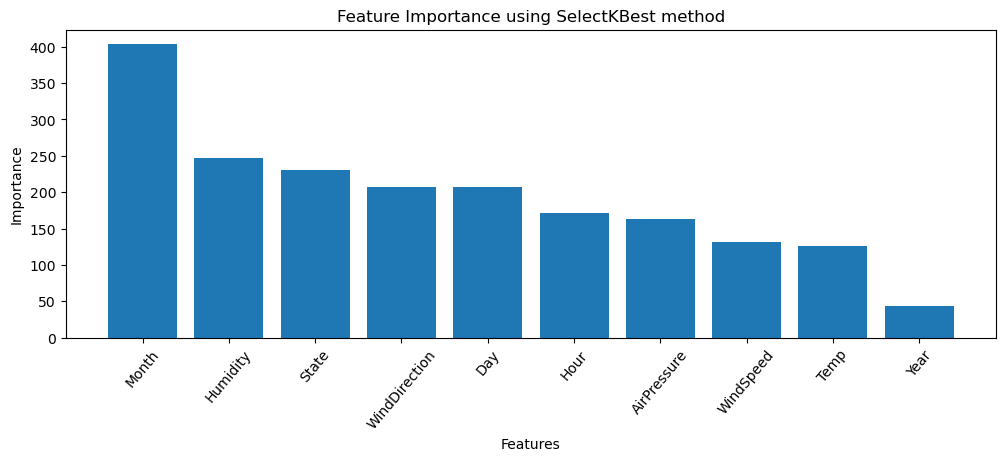

In [21]:
plt.figure(figsize = (12, 4))
plt.bar(featureScores.Features, featureScores.feature_imp)
plt.xticks(rotation = 50)
plt.xlabel("Features")
plt.ylabel("Importance")
plt.title("Feature Importance using SelectKBest method")
plt.show()

In [22]:
xtrain, xtesta, ytrain, ytest = train_test_split(input_features, target, test_size=0.2, random_state=1)

In [23]:
scaler = StandardScaler()
xtrain = scaler.fit_transform(xtrain)
xtest = scaler.transform(xtesta)
xtrain.shape, xtest.shape

((4388, 10), (1098, 10))

In [36]:
params = {
    'learning_rate': 0.1,
    'max_depth': 6}
xgbmodel = XGBRegressor(**params)
xgbmodel.fit(xtrain, ytrain)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.1, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=6, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=100, n_jobs=None, num_parallel_tree=None,
             predictor=None, random_state=None, ...)

In [29]:
y_predxgb = xgbmodel.predict(xtest)

In [34]:
rmse = np.sqrt(mean_squared_error(ytest, y_predxgb))
r2 = r2_score(ytest, y_predxgb)
r2

0.7982365


In [35]:
#Artificial Neural Network layers
model = None
model = Sequential()
model.add(Dense(128, activation='relu', input_dim=10))
model.add(Dropout(0.33))
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.33))
model.add(Dense(32, activation='relu'))
model.add(Dropout(0.33))
model.add(Dense(32, activation='relu'))
model.add(Dropout(0.33))
model.add(Dense(32, activation='relu'))
model.add(Dropout(0.33))
model.add(Dense(1, activation='linear'))
model.compile(metrics='mse', loss='mae', optimizer=Adam(learning_rate=0.001))
print(model.summary())

Metal device set to: Apple M2
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 128)               1408      
                                                                 
 dropout (Dropout)           (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 64)                8256      
                                                                 
 dropout_1 (Dropout)         (None, 64)                0         
                                                                 
 dense_2 (Dense)             (None, 32)                2080      
                                                                 
 dropout_2 (Dropout)         (None, 32)                0         
                                                                 
 dense_3 (Dense)          

In [27]:
history = model.fit(xtrain, ytrain, validation_split=0.1, epochs=30, batch_size=32)

Epoch 1/30


2023-04-10 19:10:25.997967: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


124/124 [==============================] - 1s 8ms/step - loss: 372.3318 - mse: 204925.6094 - val_loss: 218.8990 - val_mse: 67990.4688
Epoch 2/30
124/124 [==============================] - 1s 6ms/step - loss: 215.4410 - mse: 69585.8125 - val_loss: 192.4637 - val_mse: 54038.8672
Epoch 3/30
124/124 [==============================] - 1s 6ms/step - loss: 189.7988 - mse: 54387.1797 - val_loss: 179.8190 - val_mse: 47477.4688
Epoch 4/30
124/124 [==============================] - 1s 6ms/step - loss: 177.4871 - mse: 47538.5898 - val_loss: 170.0776 - val_mse: 43535.4023
Epoch 5/30
124/124 [==============================] - 1s 6ms/step - loss: 165.3159 - mse: 42108.6289 - val_loss: 169.9317 - val_mse: 43242.7539
Epoch 6/30
124/124 [==============================] - 1s 6ms/step - loss: 150.4990 - mse: 35423.5742 - val_loss: 146.3241 - val_mse: 32503.1699
Epoch 7/30
124/124 [==============================] - 1s 6ms/step - loss: 136.8776 - mse: 30528.2188 - val_loss: 128.0136 - val_mse: 25405.3242
Ep

In [28]:
y_pred = model.predict(xtest)

35/35 [==============================] - 0s 2ms/step


In [29]:
xy = pd.DataFrame(xtesta)

In [30]:
scores = model.evaluate(xtest, ytest)
mae = scores[0]
mse = scores[1]

35/35 [==============================] - 0s 4ms/step - loss: 93.9583 - mse: 14411.1084


In [31]:
print('Mean absolute error: ', mae)
print('Mean squared error: ', mse)

Mean absolute error:  93.95832824707031
Mean squared error:  14411.1083984375


In [32]:
r2_score(ytest,y_pred) #R2 score for ANN

0.7975642447655877

In [33]:
df2 = pd.read_excel("/Users/nithya/Downloads/J comp/state_test.xlsx")

In [34]:
df2.shape

(28, 10)

In [35]:
df3 = df2.copy()

In [36]:
df2 = scaler.transform(df2)

In [37]:
y_preda = model.predict(df2)

1/1 [==============================] - 0s 25ms/step


In [38]:
df3.head()

,Temp,Humidity,WindSpeed,WindDirection,AirPressure,State,Year,Month,Day,Hour
0,30.71,36.15,2.83,55,95423,0,2015,11,12,9
1,19.78,47.65,1.17,158,90845,1,2015,1,21,7
2,27.78,75.60,0.55,280,91791,2,2015,5,11,6
3,22.59,51.20,0.48,260,100999,3,2015,1,6,11
4,28.21,48.60,2.62,59,98252,4,2015,11,10,5


In [39]:
df3['State'] = label_encoder.inverse_transform(df3['State'])

In [40]:
df3['Predicted'] = y_preda

In [41]:
ytesta = pd.read_excel("/Users/nithya/Downloads/J comp/ytesta.xlsx")

In [42]:
ytesta.to_numpy().shape

(28, 1)

In [43]:
df3['Actual'] = ytesta

In [44]:
df3 #Sample predictions for neural network

,Temp,Humidity,WindSpeed,WindDirection,AirPressure,State,Year,Month,Day,Hour,Predicted,Actual
0,30.71,36.15,2.83,55,95423,andhra pradesh,2015,11,12,9,538.497314,659.00
1,19.78,47.65,1.17,158,90845,arunachal pradesh,2015,1,21,7,579.009766,515.00
2,27.78,75.60,0.55,280,91791,assam,2015,5,11,6,725.885376,395.00
3,22.59,51.20,0.48,260,100999,bihar,2015,1,6,11,192.246933,102.00
4,28.21,48.60,2.62,59,98252,chhattisgarh,2015,11,10,5,590.484985,843.00
5,10.79,92.50,1.59,305,98969,delhi,2015,3,12,2,105.945969,333.00
6,28.29,45.20,0.76,343,100251,goa,2015,1,8,5,733.121460,620.00
7,29.47,22.95,2.90,60,100685,gujarat,2015,2,4,9,649.399597,242.00
8,19.54,87.60,1.52,113,98861,haryana,2015,4,13,1,36.110638,16.00
9,16.18,43.00,1.10,252,78671,himachal pradesh,2015,5,10,9,721.834961,1081.00


In [45]:
#r2_score(ytesta,y_preda)

0.2958423195659854

In [38]:
#Support Vector Regression
from sklearn.svm import SVR
regressor = SVR(kernel = 'linear')
regressor.fit(xtrain, ytrain)

SVR(kernel='linear')

In [47]:
ypredb = regressor.predict(xtest)

In [48]:
r2_score(ytest,ypredb)

0.28819338561956365

In [39]:
from sklearn.linear_model import LinearRegression
lr = LinearRegression()
lr.fit(xtrain, ytrain)

LinearRegression()

In [50]:
ypredc = lr.predict(xtest)

In [51]:
r2_score(ytest,ypredc)

0.2988229918724554

In [65]:
#Combining models for hybrid - 60% weightage given for ANN, rest given for SVR and LinearRegression
def pred(val):
    pred1 = model.predict(val)
    pred2 = regressor.predict(val)
    pred3 = lr.predict(val)
    ret = []
    for i in range(len(pred1)):
        ret.append((pred1[i]*0.6 + pred2[i]*0.2 + pred3[i]*0.2))
    return ret

In [66]:
df4 = df3.copy()

In [67]:
df4['Predicted'] = pred(df2)

1/1 [==============================] - 0s 77ms/step


In [68]:
df4 #Sample predictions for hybrid model

,Temp,Humidity,WindSpeed,WindDirection,AirPressure,State,Year,Month,Day,Hour,Predicted,Actual
0,30.71,36.15,2.83,55,95423,andhra pradesh,2015,11,12,9,[561.4588],659.00
1,19.78,47.65,1.17,158,90845,arunachal pradesh,2015,1,21,7,[559.0509],515.00
2,27.78,75.60,0.55,280,91791,assam,2015,5,11,6,[639.6577],395.00
3,22.59,51.20,0.48,260,100999,bihar,2015,1,6,11,[231.385],102.00
4,28.21,48.60,2.62,59,98252,chhattisgarh,2015,11,10,5,[577.97296],843.00
5,10.79,92.50,1.59,305,98969,delhi,2015,3,12,2,[132.40822],333.00
6,28.29,45.20,0.76,343,100251,goa,2015,1,8,5,[682.2949],620.00
7,29.47,22.95,2.90,60,100685,gujarat,2015,2,4,9,[620.8058],242.00
8,19.54,87.60,1.52,113,98861,haryana,2015,4,13,1,[156.30273],16.00
9,16.18,43.00,1.10,252,78671,himachal pradesh,2015,5,10,9,[683.34094],1081.00


In [69]:
y_predhybrid = pred(xtest)

35/35 [==============================] - 0s 2ms/step


In [70]:
r2_score(ytest,y_predhybrid) #R2 score for hybrid model

0.708107094433251

In [40]:
#Combining models for hybrid - SVR, LR, XGBRegressor
def predml(val):
    pred1 = xgbmodel.predict(val)
    pred2 = regressor.predict(val)
    pred3 = lr.predict(val)
    ret = []
    for i in range(len(pred1)):
        ret.append((pred1[i]*0.6 + pred2[i]*0.2 + pred3[i]*0.2))
    return ret

In [41]:
y_predhybridml = predml(xtest)

In [42]:
r2_score(ytest,y_predhybridml)

0.786511589159407